<a href="https://colab.research.google.com/github/MrCoeg/Skripsi/blob/main/Experimen_2%20~%20Meningkatkan%20keypoint%20menjadi%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidiamsi

/bin/bash: nvidiamsi: command not found


In [ ]:
# !unzip '/content/drive/MyDrive/Dataset/rgb.zip' -d '/content/drive/MyDrive/Dataset'

In [1]:
# Menghubungkan ke Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm

# Variabel Parameter Kontrol Program

# Index dari N-Keypoint yang dipilih
INDEX_KEYPOINTS = [0, 4, 8, 12, 16, 20]
N_KEYPOINTS = 6

# Channel warna pada input image
N_IMG_CHANNELS = 3
# Size Image setelah tahap preprocesing resize
MODEL_IMG_SIZE = 224

RAW_IMG_SIZE = 224

# Property dari mean dan stds dataset untuk normalisasi
# Nilai didapat menggunakan get_norm_params
DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

# Neuron model CNN
MODEL_NEURONS = 16

# Blur Size
fg_size = 51
fgk_size = 5

# colormap untuk matplotlib
COLORMAP = {
    "thumb": {"ids": [0, 1, 2], "color": "g"},
    "index": {"ids": [0, 3, 4], "color": "c"},
    "middle": {"ids": [0, 5, 6], "color": "b"},
    "ring": {"ids": [0, 7, 8], "color": "m"},
    "little": {"ids": [0, 9, 10], "color": "r"},
}

# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (fg_size, fg_size), fgk_size)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred

# Loss function IoU
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / 128

# Visualisasi sample data
def show_data(dataset, n_samples=4):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)
        plt.imshow(image)

        # mendapatkan heatmap image input
        heatmaps = sample["heatmaps"].numpy()

        # mengubah heatmap image input menjadi keypoint
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                input_keypoints[params["ids"], 0],
                input_keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

In [2]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 13000
            n_end = 13120

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),

            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        image_name = self.image_names[idx]

        # instance image menggunakan PIL
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()
        if 0 < flip_probability < 0.25:
          image = self.image_transform(image_raw)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image_raw)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image_raw)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237664


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):

        # Preparation
        conv_re = self.conv_in(x)

        #Left-Low
        conv_d1 = self.conv_down1(self.maxpool(conv_re))
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))

        # Feature Mapping
        conv_b = self.conv_bottleneck(conv_d4)

        #
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237664


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.ReLU(inplace=True),

        )

    def forward(self, x):
        return self.double_conv(x)


class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), conv_d3], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), conv_d2], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), conv_d1], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  237664


In [3]:
import torch
import torch.nn as nn

class ResiudalBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),
        )

    def forward(self, x):
        residual = self.double_conv(x);
        return residual + x


class DepthwiseSeparableConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        self.double_conv = nn.Sequential(

            nn.BatchNorm2d(in_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=False),
            nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),

            nn.BatchNorm2d(out_depth),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=3,stride=1,padding=1,groups=out_depth,bias=False),
            nn.Conv2d(in_channels=out_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=False),


        )

    def forward(self, x):
        return self.double_conv(x)

class DepthwiseUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # ConvBlock Encoder
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channel, MODEL_NEURONS, kernel_size=3, padding=1, bias=False),
        )
        self.conv_down1 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS)
        self.skip_1 = ResiudalBlock(MODEL_NEURONS, MODEL_NEURONS)

        self.conv_down2 = DepthwiseSeparableConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.skip_2 = ResiudalBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 2)

        self.conv_down3 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.skip_3 = ResiudalBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 4)

        self.conv_down4 = DepthwiseSeparableConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # ConvBlock Bottleneck
        self.conv_bottleneck = DepthwiseSeparableConvBlock(MODEL_NEURONS * 8, MODEL_NEURONS * 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # ConvBlock Decoder
        self.conv_up1 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 16 + MODEL_NEURONS * 8, MODEL_NEURONS * 8
        )
        self.conv_up2 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up3 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up4 = DepthwiseSeparableConvBlock(
            MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
        )


        # Output layer
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )



    def forward(self, x):
        conv_re = self.conv_in(x)
        conv_d1 = self.conv_down1(conv_re)
        skip_d11 = self.skip_1(conv_d1)
        skip_d12 = self.skip_1(skip_d11)

        pool1 = self.maxpool(conv_d1)
        conv_d2 = self.conv_down2(pool1)
        skip_d21 = self.skip_2(conv_d2)
        skip_d22 = self.skip_2(skip_d21)


        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        skip_d31 = self.skip_3(conv_d3)
        skip_d32 = self.skip_3(skip_d31)


        conv_d4 = self.conv_down4(self.maxpool(conv_d3))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d4))
        conv_u1 = self.conv_up1(torch.cat([self.upsample(conv_b), conv_d4], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsample(conv_u1), skip_d32], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsample(conv_u2), skip_d22], dim=1))
        conv_u4 = self.conv_up4(torch.cat([self.upsample(conv_u3), skip_d12], dim=1))
        out = self.conv_out(conv_u4)
        return out

depthwise_model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

Depthwise Parameter :  251456


In [ ]:
'''
Hourglass network inserted in the pre-activated Resnet
Use lr=0.01 for current version
(c) YANG, Wei
'''
import torch.nn as nn
import torch.nn.functional as F

# from .preresnet import BasicBlock, Bottleneck


__all__ = ['HourglassNet', 'hg']

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes*block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)
        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n-1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)
        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        out = up1 + up2
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    '''Hourglass model from Newell et al ECCV 2016'''
    def __init__(self, block, num_stacks=2, num_blocks=4, num_classes=16):
        super(HourglassNet, self).__init__()

        self.inplanes = 64
        self.num_feats = 128
        self.num_stacks = num_stacks
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=True)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        # build hourglass modules
        ch = self.num_feats*block.expansion
        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, 4))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(nn.Conv2d(ch, num_classes, kernel_size=1, bias=True))
            if i < num_stacks-1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1, bias=True))
                score_.append(nn.Conv2d(num_classes, ch, kernel_size=1, bias=True))
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=True)
        return nn.Sequential(
                conv,
                bn,
                self.relu,
            )

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            y = self.fc[i](y)
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_

        return out


def hg(**kwargs):
    model = HourglassNet(Bottleneck, num_stacks=kwargs['num_stacks'], num_blocks=kwargs['num_blocks'],
                         num_classes=kwargs['num_classes'])
    return model

In [ ]:
!pip install torchviz

Depthwise Parameter :  3585932


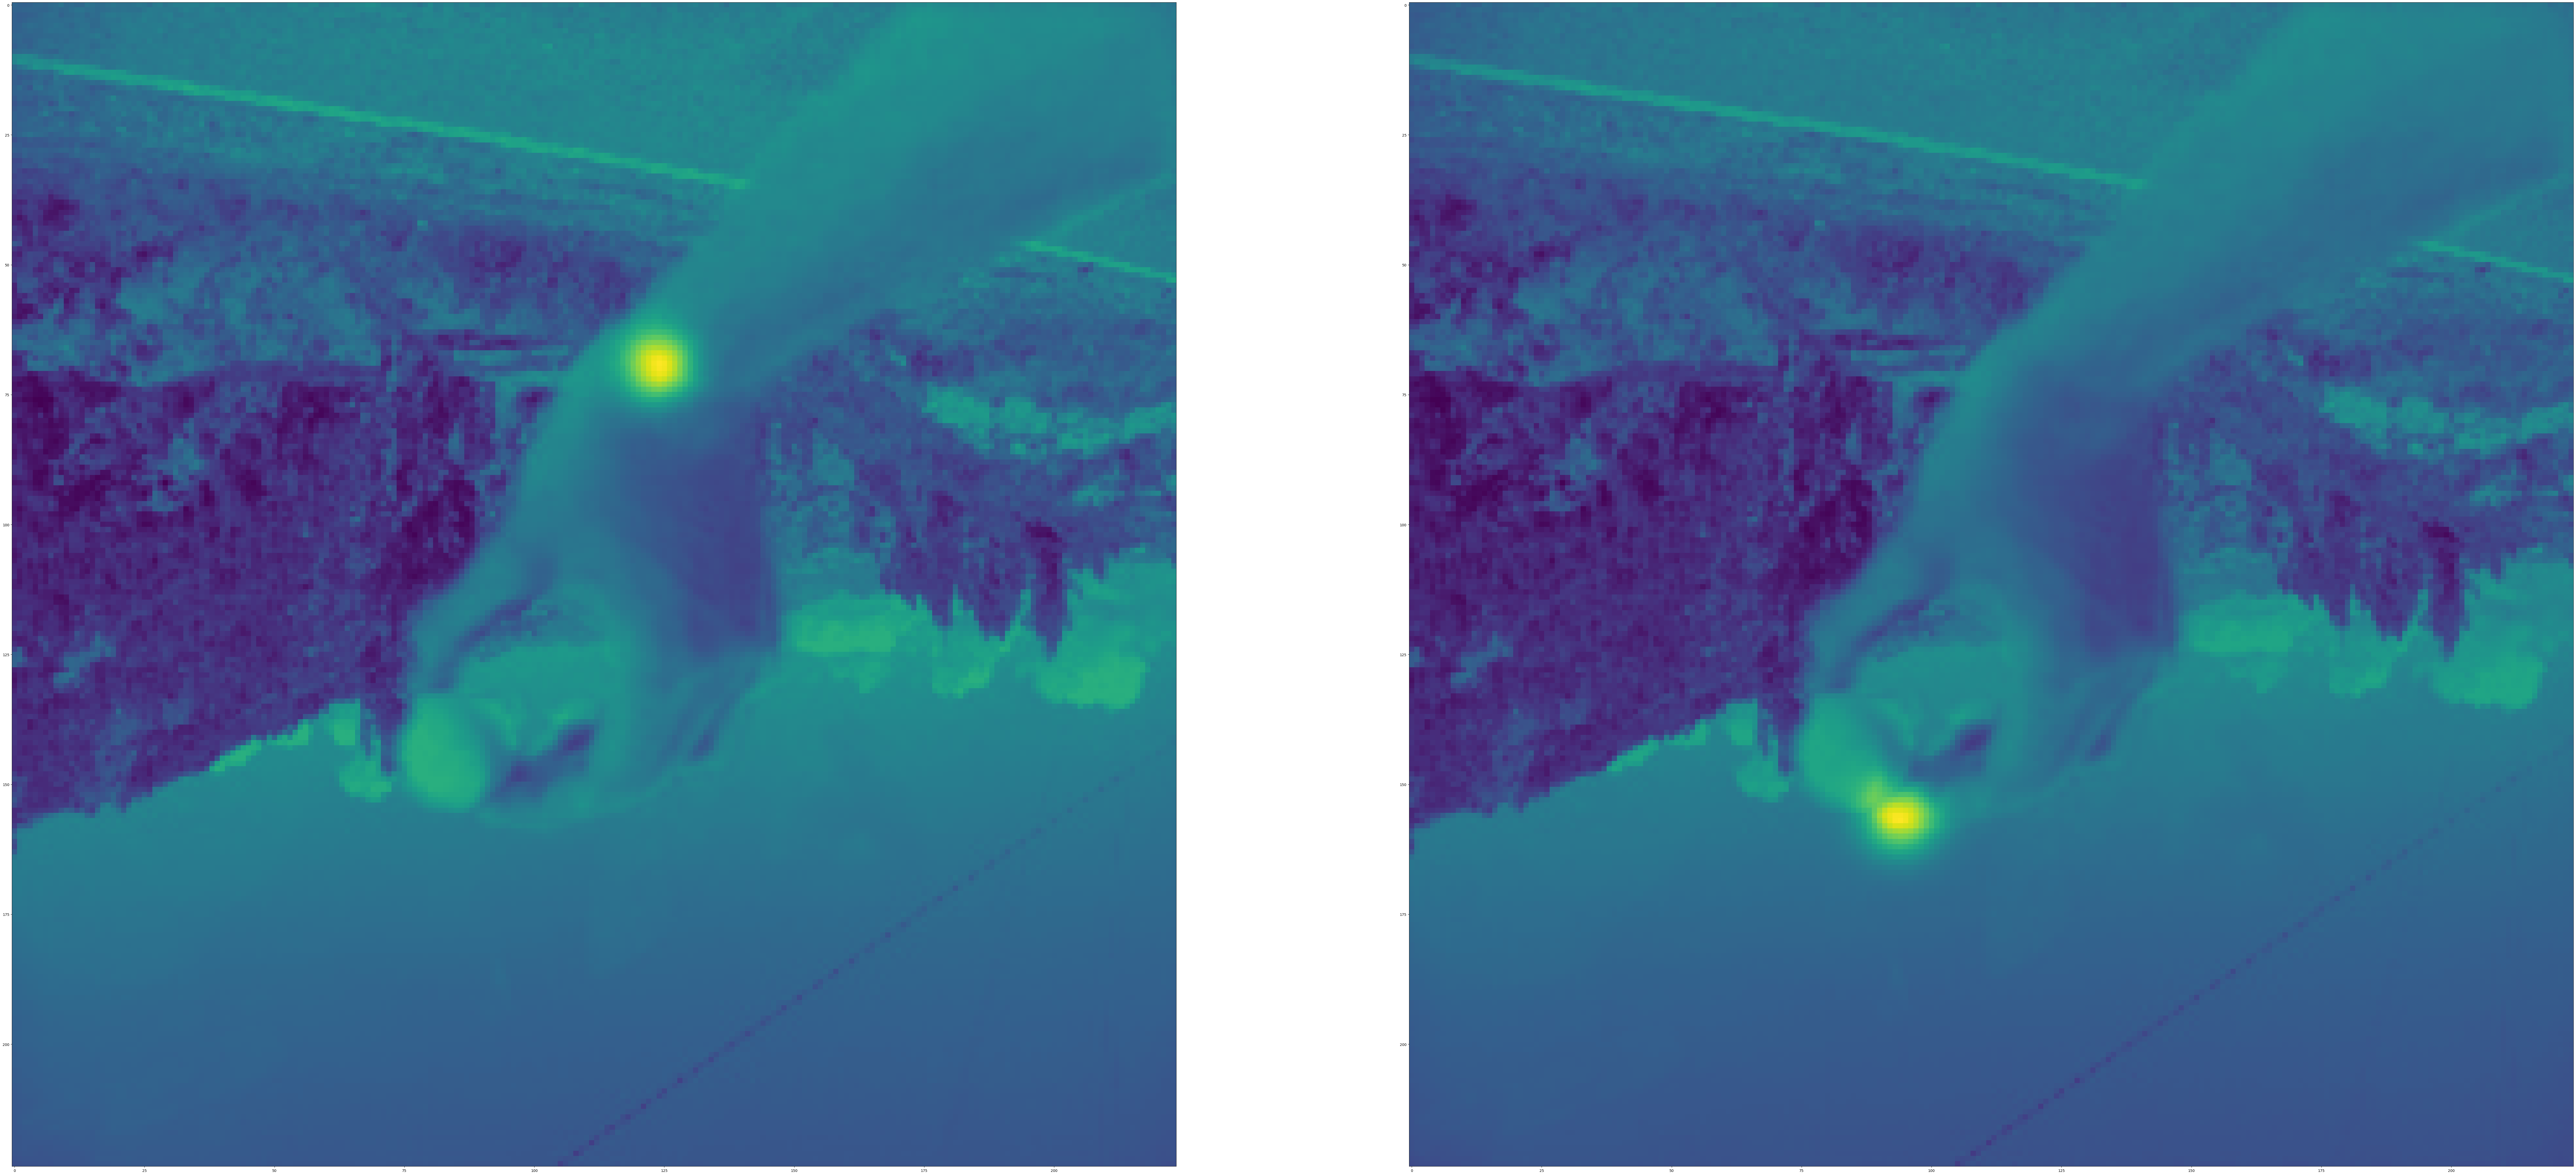

TypeError: ignored

In [ ]:
depthwise_model = HourglassNet(Bottleneck  ,num_stacks=1, num_blocks=1 ,num_classes=12)
depthwise_parameter = sum(p.numel() for p in depthwise_model.parameters() if p.requires_grad)
print(f'Depthwise Parameter : ', depthwise_parameter)

import torchviz
from torchviz import make_dot

for i, data in enumerate(val_dataloader, 0):
  if(i == 0):
    heatmaps = data["heatmaps"]
    plt.figure(figsize=[128, 128])
    bb = 1
    for k in range(N_KEYPOINTS):
      plt.subplot(1, N_KEYPOINTS, k+1)
      plt.imshow((data["image"][1][1])/4 + (heatmaps[1][k]) )
    break;
plt.show()

make_dot(data, params=dict(list(depthwise_model.named_parameters()))).render("rnn_torchviz", format="png")

In [ ]:
normal_model = Hourglass(4, 3)
depthwise_parameter = sum(p.numel() for p in normal_model.parameters() if p.requires_grad)
print(f'Normal Model Parameter : ', depthwise_parameter)
normal_model.eval()

In [41]:
import torch
import torch.nn as nn
MODEL_NEURONS = 2
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()

        # membuat model block arsitektur U-Net
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # Membuat model U-Net sesuai dengan arsitektur pada slide presentasi

        # membuat ConvBlock Encoder dengan  3 Input Neuron dan output 16 Neuron
        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)

        # membuat ConvBlock Encoder dengan 16 Neuron dan output 32 Neuron
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)

        # membuat ConvBlock Encoder dengan 32 Neuron dan output 64 Neuron
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)

        # membuat ConvBlock Encoder dengan 64 Neuron dan output 128 Neuron
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        # membuat layer maxpool2d 2x2
        self.maxpool = nn.MaxPool2d(2)

        # membuat layer updsample 2x2
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        # membuat ConvBlock Decoder dengan 128 Neuron + 64 Neuron Concatination dan output 64 Neuron
        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )

        # membuat ConvBlock Decoder dengan 64 Neuron + 32 Neuron Concatination dan output 32 Neuron
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )

        # membuat ConvBlock Decoder dengan 32 Neuron + 16 Neuron Concatination dan output 16 Neuron
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        # membuat Output layer dengan 16 Neuron dan output N-Keypoint
        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self):

        # Menyambungkan input image terhadap layer conv encoder 1
        conv_d1 = self.conv_down1(x)
        # Menyambungkan conv encoder 1 terhadap layer conv encoder 2 dengan down sampling
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        # Menyambungkan conv encoder 2 terhadap layer conv encoder 3 down sampling
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))

        # Menyambungkan conv encoder 3 terhadap layer bottleneck dengan down sampling
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        # Menyambungkan bottleneck  bersama conv encoder 3 dengan menggunakan concatination terhadap layer decoder 1 dengan up sampling
        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        # Menyambungkan decoder 1  bersama conv encoder 2 dengan menggunakan concatination terhadap layer decoder 2 dengan up sampling
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        # Menyambungkan decoder 2  bersama conv encoder 1 dengan menggunakan concatination terhadap layer decoder 3 dengan up sampling
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        # Menyambungkan layer decoder 3 dengan output layer
        out = self.conv_out(conv_u3)

        return 1 - torch.mean(torch.randn((1)))

input_shape = (1, 3, 224, 224)  # Batch size x Channels x Height x Width
input_tensor = torch.randn(input_shape)


normal_model = ShallowUNet(3,3)
depthwise_parameter = sum(p.numel() for p in normal_model.parameters() if p.requires_grad)
print(f'Normal Model Parameter : ', depthwise_parameter)

Normal Model Parameter :  7910


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, block_name):
        super(BottleneckBlock, self).__init__()

        # Skip layer
        if in_channels == out_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        # Residual: 3 conv blocks [out_channels/2 -> out_channels/2 -> out_channels]
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = F.relu(out)

        return out

class HourglassModule(nn.Module):
    def __init__(self, in_channels, num_classes, num_channels, bottleneck, hgid):
        super(HourglassModule, self).__init__()

        self.left_features = self.create_left_half_blocks(in_channels, bottleneck, hgid, num_channels)
        self.right_features = self.create_right_half_blocks(self.left_features, bottleneck, hgid, num_channels)

        self.head_next_stage, self.head_parts = self.create_heads(in_channels, self.right_features, num_classes, hgid, num_channels)

    def create_left_half_blocks(self, in_channels, bottleneck, hgid, num_channels):
        hgname = 'hg{}'.format(hgid)

        f1 = bottleneck(in_channels, num_channels, hgname + '_l1')
        x = nn.MaxPool2d(kernel_size=2, stride=2)(f1)

        f2 = bottleneck(num_channels, num_channels, hgname + '_l2')
        x = nn.MaxPool2d(kernel_size=2, stride=2)(f2)

        f4 = bottleneck(num_channels, num_channels, hgname + '_l4')
        x = nn.MaxPool2d(kernel_size=2, stride=2)(f4)

        f8 = bottleneck(num_channels, num_channels, hgname + '_l8')

        return f1, f2, f4, f8

    def connect_left_to_right(self, left, right, bottleneck, name, num_channels):
        xleft = bottleneck(left, num_channels, name + '_connect')
        xright = F.interpolate(right, scale_factor=2, mode='nearest')
        out = xleft + xright
        out = bottleneck(out, num_channels, name + '_connect_conv')
        return out

    def bottom_layer(self, lf8, bottleneck, hgid, num_channels):
        lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

        x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
        x = bottleneck(x, num_channels, str(hgid) + "_lf8_x2")
        x = bottleneck(x, num_channels, str(hgid) + "_lf8_x3")

        rf8 = x + lf8_connect
        return rf8

    def create_right_half_blocks(self, left_features, bottleneck, hgid, num_channels):
        lf1, lf2, lf4, lf8 = left_features

        rf8 = self.bottom_layer(lf8, bottleneck, hgid, num_channels)

        rf4 = self.connect_left_to_right(lf4, rf8, bottleneck, 'hg{}_rf4'.format(hgid), num_channels)

        rf2 = self.connect_left_to_right(lf2, rf4, bottleneck, 'hg{}_rf2'.format(hgid), num_channels)

        rf1 = self.connect_left_to_right(lf1, rf2, bottleneck, 'hg{}_rf1'.format(hgid), num_channels)

        return rf1

    def create_heads(self, prelayer_features, rf1, num_classes, hgid, num_channels):
        head = nn.Conv2d(num_channels, num_channels, kernel_size=1, stride=1, padding=0)(rf1)
        head = nn.BatchNorm2d(num_channels)(head)

        head_parts = nn.Conv2d(num_channels, num_classes, kernel_size=1, stride=1, padding=0)(head)

        head = nn.Conv2d(num_channels, num_channels, kernel_size=1, stride=1, padding=0)(head)
        head = nn.BatchNorm2d(num_channels)(head)

        head_m = nn.Conv2d(num_classes, num_channels, kernel_size=1, stride=1, padding=0)(head_parts)

        head_next_stage = head + head_m + prelayer_features

        return head_next_stage, head_parts

class HourglassNetwork(nn.Module):
    def __init__(self, num_classes, num_stacks, num_channels, inres, outres, bottleneck):
        super(HourglassNetwork, self).__init__()

        self.front_features = self.create_front_module(num_channels, bottleneck)

        self.hourglass_modules = nn.ModuleList()
        for i in range(num_stacks):
            self.hourglass_modules.append(HourglassModule(num_channels, num_classes, num_channels, bottleneck, i))

    def create_front_module(self, num_channels, bottleneck):
        front_module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            bottleneck(64, num_channels // 2, 'front_residual_x1'),
            nn.MaxPool2d(kernel_size=2, stride=2),
            bottleneck(num_channels // 2, num_channels // 2, 'front_residual_x2'),
            bottleneck(num_channels // 2, num_channels, 'front_residual_x3')
        )
        return front_module

    def forward(self, x):
        features = self.front_features(x)
        outputs = []

        for i, hg_module in enumerate(self.hourglass_modules):
            features, head_to_loss = hg_module(features)
            outputs.append(head_to_loss)

        return outputs

# Create an instance of the HourglassNetwork
num_classes = 10
num_stacks = 2
num_channels = 128
inres = (256, 256)
outres = (64, 64)
BottleneckBlock = BottleneckBlock()
model = HourglassNetwork(num_classes, num_stacks, num_channels, inres, outres, BottleneckBlock)
model.eval()

TypeError: ignored

In [4]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            print(self.optimizer)

            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            labels = data["heatmaps"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss
            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())
            print(i)
            # final loss untuk epoch training ini
            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                labels = data["heatmaps"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break


In [5]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

import sys
sys.path.append("../")

In [6]:
config = {
    "data_dir": "/content/drive/My Drive/Dataset",
    "epochs": 1000,
    "batch_size": 48,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 40,
    "learning_rate": 0.5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [7]:
# membuat training dataset
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

In [ ]:
for i, data in enumerate(val_dataloader, 0):
  if(i == 0):
    heatmaps = data["heatmaps"]
    plt.figure(figsize=[128, 128])
    bb = 1
    for k in range(N_KEYPOINTS):
      plt.subplot(1, N_KEYPOINTS, k+1)
      plt.imshow((data["image"][1][1])/4 + (heatmaps[1][k]) )
    break;
plt.show()



error: ignored

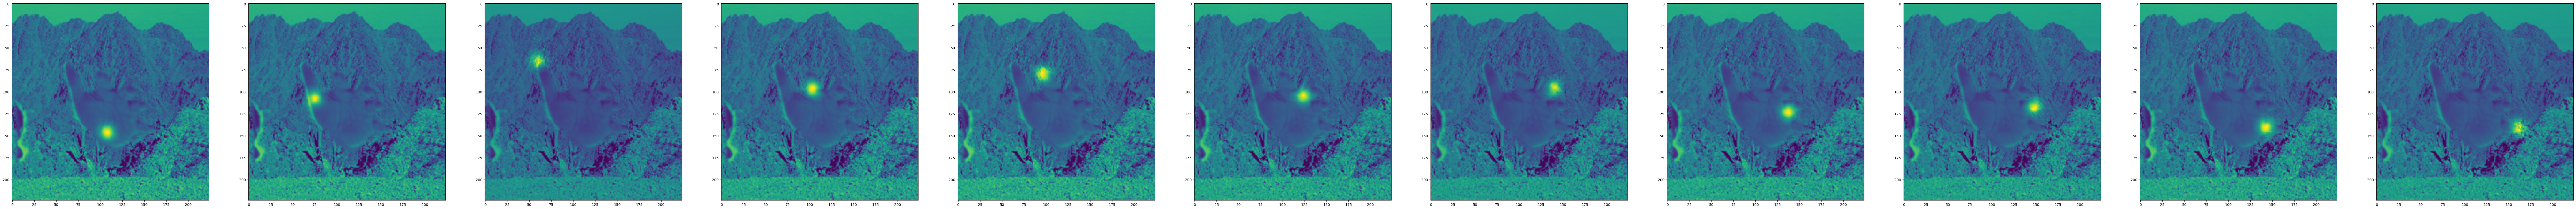

In [ ]:



plt.figure(figsize=[128, 128])
for k in range(N_KEYPOINTS):
  plt.subplot(1, N_KEYPOINTS, k+1)
  plt.imshow((data["image"][1][1])/4 + (data["heatmaps"][1][k]) )

[9135 6468 4238]


IndexError: ignored

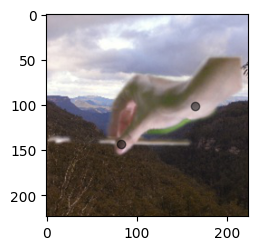

In [ ]:
# visualisasi training dataset
show_data(train_dataset, n_samples=4)

In [ ]:
# print(get_norm_params(train_dataloader))

In [8]:
# membuat eval dataset
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

In [ ]:
# visualisasi eval dataset
show_data(val_dataset, n_samples=8)

In [9]:
# membuat model U-Net
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

# membuat loss function
criterion = IoULoss()

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])

# membuat scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=5, verbose=True, threshold=0.00001
)

model.eval()

DepthwiseUNet(
  (conv_in): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      (7): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (skip_1): ResiudalBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d

In [ ]:
# membuat trainer
trainer = Trainer(model, criterion, optimizer, config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Epoch: 1/1000, Train Loss=0.9931738663, Val Loss=0.9917333344
SGD (
Parameter Group 0
    dampening: 0
    dif

In [ ]:
# save model
torch.save(model.state_dict(), "/content/fine")

In [ ]:
#visualisasi graphic training dan eval

plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()
print('/content/drive/My Drive/Skripsi_GoogleColab/data/training/rgb/.ipynb_checkpoints')

In [16]:
# Config testing
config = {
    "data_dir": "/content/drive/My Drive/Dataset",
    "model_path": "model_020",
    "test_batch_size": 4,
    "device": torch.device("cuda"),
}

In [ ]:
# membuat dataset testing
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

In [ ]:
import matplotlib
# load model
model_test = DepthwiseUNet(3, 2)
model_test.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device("cuda"))
)


In [25]:
image_raw = Image.open("00032701.jpg")
transform = transforms.Compose(
    [
        transforms.Resize(MODEL_IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
    ]
)
image_raw = transform(image_raw)
image_raw = image_raw[None,:, :, :]

In [ ]:
pred = model_test(image_raw)
pred = pred.detach().numpy()

plt.figure(figsize=[64, 64])
for i in range(len(pred[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /10) + (pred[0][i] * 2))

In [ ]:
model1 = model_test.conv_in(image_raw)
output_model1 = model1.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(16):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model1[0][i])

plt.show()

In [ ]:
model2 = model_test.conv_down1(model1)
output_model2 = model2.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model2[0][i])

plt.show()

In [ ]:
model3 = model_test.conv_down2(model_test.maxpool(model2))
output_model3= model3.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model3[0][i])

plt.show()

In [ ]:
model4 = model_test.conv_down3(model_test.maxpool(model3))
output_model4 = model4.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model4[0][i])

plt.show()

In [ ]:
model_new = model_test.conv_down4(model_test.maxpool(model4))
output_model_new = model_new.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model_new[0][i])

plt.show()

In [ ]:
model5 = model_test.conv_bottleneck(model_test.maxpool(model_new))
output_model5 = model5.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model5[0][i])

plt.show()

In [ ]:
model6 = model_test.conv_up1(torch.cat([model_test.upsample(model5), model_new], dim=1))
output_model6 = model6.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model6[0][i])

plt.show()


In [ ]:
model7 = model_test.conv_up2(torch.cat([model_test.upsample(model6), model4], dim=1))
output_model7 = model7.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model7[0][i])

plt.show()



In [ ]:
model8 = model_test.conv_up3(torch.cat([model_test.upsample(model7), model3], dim=1))
output_model8 = model8.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model8[0][i])

plt.show()



In [ ]:
model9 = model_test.conv_up4(torch.cat([model_test.upsample(model8), model2], dim=1))
output_model9 = model9.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model1[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow(output_model9[0][i])

plt.show()


In [ ]:
model10 = model_test.conv_out(model9)
output_model10 = model10.detach().numpy()


plt.figure(figsize=[64, 64])

for i in range(len(model10[0])):
  plt.subplot(1, 16, i+1)
  plt.imshow((image_raw[0][0] /4) + (output_model10[0][i] * 2))

plt.show()

In [ ]:
# melakukan testing
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

In [ ]:
# visualisasi testing
for data in test_dataloader:
    show_batch_predictions(data, model)
    break